<a href="https://colab.research.google.com/github/makxxic/NOTEBOOKS/blob/main/Stage5_Task_Starter_Breast_Cancer_Dataset_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Breast Cancer Dataset Classifier**

The following link https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data contains data that correlates the features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. It is used to classify the mass as either benign (B) or malignant (M).

You are required to implement a 3-layer neural network to classify a breast mass sample based on this dataset. Ensure each step of the process is properly documented using a text block in your notebook just before the code block. Implement in a Jupyter Notebook and submit the link below.



#### **Requirements:**

- Implement a 90% - 10% test train split. Ensure your data is well shuffled before splitting.
- Your neural network should have 2 hidden and 1 output layers.
- Use the ReLU activation for hidden layers and the sigmoid function for the output layer.
- Train your model with with SGD optimizer and choose an appropriate learning rate and criterion.
- Implement L2 regularization in your model to avoid overfitting.
- Your model must achieve 99% accuracy on the test dataset
- Implement early stopping to minimize computational resources
- At the end of the training print out the following:
  - Accuracy of the model on the validation data
  - Number of epochs to get to that accuracy
  - Criterion used

In [ ]:
"""
Insert your imports here
"""
import kagglehub as kh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.optim import SGD
import torch.optim as optim

In [ ]:
"""
Download the breast dataset
"""
path = kh.dataset_download("uciml/breast-cancer-wisconsin-data")

df = pd.read_csv(path + "/data.csv")

df.head()

Using Colab cache for faster access to the 'breast-cancer-wisconsin-data' dataset.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### Implement feature engineering

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd # Re-import pandas for data loading if df needs to be reset
import kagglehub as kh # Re-import kagglehub for data loading
import numpy as np # For np.nan

"""
Implement feature engineering on the data.
"""
# Re-load the dataset to ensure a clean state, if df was corrupted in previous runs
path = kh.dataset_download("uciml/breast-cancer-wisconsin-data")
df = pd.read_csv(path + "/data.csv")

# Convert labels to binary, using replace for robustness
df['diagnosis'] = df['diagnosis'].replace({'M':1, 'B':0})

# Drop unnecessary columns, ignore if not found
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# Features
X = df.drop('diagnosis', axis=1).values
# Target
y = df['diagnosis'].values

# Handle potential NaNs in y before scaling or splitting
nan_mask = np.isnan(y)
if np.any(nan_mask):
    # Drop rows with NaN in diagnosis from both X and y
    X = X[~nan_mask]
    y = y[~nan_mask]
    print(f"Removed {np.sum(nan_mask)} rows with NaN values in 'diagnosis'.")

# Initialize scaler and scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Using Colab cache for faster access to the 'breast-cancer-wisconsin-data' dataset.


/tmp/ipython-input-1791357258.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'M':1, 'B':0})


In [ ]:
# Print the shape of the features and target to verify
print(f"Features shape: {X.shape}") # Should be (569, 30)
print(f"Target shape: {y.shape}")   # Should be (569,)

Features shape: (569, 30)
Target shape: (569,)


In [ ]:
processed_df = df.copy()    # Note: change this line of code!!!


In [ ]:
"""
Split processed dataframe into test and validation sets.
"""
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

In [ ]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 512
Validation samples: 57


In [ ]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit the scaler on the TRAINING data only, then transform the training data
# We do not fit on validation data to prevent "data leakage" (cheating)
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data using the stats learned from the training data
X_val_scaled = scaler.transform(X_val)

In [ ]:
"""
Get the PyTorch tensors
"""
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [ ]:
# Define the Neural Network class inheriting from nn.Module
class BreastCancerNN(nn.Module):
    def __init__(self, input_features):
        super(BreastCancerNN, self).__init__()

        # First Hidden Layer: Transforms input (30 features) to 32 hidden neurons
        self.layer1 = nn.Linear(in_features=input_features, out_features=32)
        self.relu1 = nn.ReLU() # Activation function

        # Second Hidden Layer: Transforms 32 inputs to 16 hidden neurons
        self.layer2 = nn.Linear(in_features=32, out_features=16)
        self.relu2 = nn.ReLU() # Activation function

        # Output Layer: Transforms 16 inputs to 1 output (probability score)
        self.layer3 = nn.Linear(in_features=16, out_features=1)
        self.sigmoid = nn.Sigmoid() # Squashes output between 0 and 1

    def forward(self, x):
        # Pass input through Layer 1 and apply ReLU
        out = self.layer1(x)
        out = self.relu1(out)

        # Pass through Layer 2 and apply ReLU
        out = self.layer2(out)
        out = self.relu2(out)

        # Pass through Layer 3 and apply Sigmoid for final prediction
        out = self.layer3(out)
        out = self.sigmoid(out)
        return out

# Determine the device to run the model on (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
# X.shape[1] is 30 (number of features)
model = BreastCancerNN(input_features=X.shape[1]).to(device)

print("Model Structure:")
print(model)

Model Structure:
BreastCancerNN(
  (layer1): Linear(in_features=30, out_features=32, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
"""
Implement your neural network architecture here
"""

model = nn.Sequential(
    # TODO: add layers here
)

In [ ]:
"""
Define hyperparameters
"""
epochs = 1000  # Maximum number of times to go through the dataset
learning_rate = 0.01
# Loss Function: Binary Cross Entropy Loss
# Used specifically for binary classification (0 or 1)
criterion = nn.BCELoss()
# Optimizer: Stochastic Gradient Descent (SGD)
# lr: learning rate
# weight_decay: L2 Regularization (0.001) helps prevent overfitting
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

print(f"Optimizer: SGD, Loss: BCELoss, LR: {learning_rate}")

Optimizer: SGD, Loss: BCELoss, LR: 0.01


In [ ]:
"""
Neural network training loop
"""

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Early stopping parameters initialized outside the loop
patience = 50
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0 # To track the epoch of the best model
best_accuracy = 0.0 # To store the best validation accuracy

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train() # Set model to training mode

    # Forward propagation
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # Backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    y_hat_class = (y_hat > 0.5).float()
    train_acc = (y_hat_class == y_train).sum().item() / float(y_train.shape[0])
    train_accuracy.append(train_acc)
    train_losses.append(loss.item())

    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Do not calculate gradients
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)

        # Calculate validation accuracy
        y_val_pred_class = (y_val_pred > 0.5).float()
        val_acc = (y_val_pred_class == y_val).sum().item() / float(y_val.shape[0])
        val_accuracy.append(val_acc)
        val_losses.append(val_loss.item())

    # Print progress
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # --- EARLY STOPPING CHECK ---
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_accuracy = val_acc # Store best accuracy
        best_epoch = epoch + 1 # Store best epoch
        patience_counter = 0 # Reset counter if we improved
        torch.save(model.state_dict(), 'best_model.pth') # Save the best model
    else:
        patience_counter += 1 # Increment counter if no improvement

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break

# Load the best model weights back
model.load_state_dict(torch.load('best_model.pth'))
print(f"Training complete. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch} with accuracy: {best_accuracy:.4f}")

Epoch [50/1000], Train Loss: 0.7016, Val Loss: 0.7010, Train Acc: 0.3750, Val Acc: 0.3860
Epoch [100/1000], Train Loss: 0.6619, Val Loss: 0.6614, Train Acc: 0.8613, Val Acc: 0.8421
Epoch [150/1000], Train Loss: 0.6189, Val Loss: 0.6191, Train Acc: 0.9004, Val Acc: 0.9123
Epoch [200/1000], Train Loss: 0.5655, Val Loss: 0.5668, Train Acc: 0.9004, Val Acc: 0.9123
Epoch [250/1000], Train Loss: 0.4986, Val Loss: 0.5014, Train Acc: 0.9160, Val Acc: 0.9123
Epoch [300/1000], Train Loss: 0.4220, Val Loss: 0.4247, Train Acc: 0.9258, Val Acc: 0.9123
Epoch [350/1000], Train Loss: 0.3475, Val Loss: 0.3474, Train Acc: 0.9316, Val Acc: 0.9474
Epoch [400/1000], Train Loss: 0.2861, Val Loss: 0.2805, Train Acc: 0.9355, Val Acc: 0.9474
Epoch [450/1000], Train Loss: 0.2405, Val Loss: 0.2288, Train Acc: 0.9355, Val Acc: 0.9825
Epoch [500/1000], Train Loss: 0.2072, Val Loss: 0.1901, Train Acc: 0.9395, Val Acc: 0.9825
Epoch [550/1000], Train Loss: 0.1825, Val Loss: 0.1609, Train Acc: 0.9434, Val Acc: 0.9825


In [ ]:
def plot_losses(plt, title, train_losses, val_losses, label):
    plt.plot(train_losses, label=f"Train {label}")
    plt.plot(val_losses, label=f"Validation {label}")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(label)

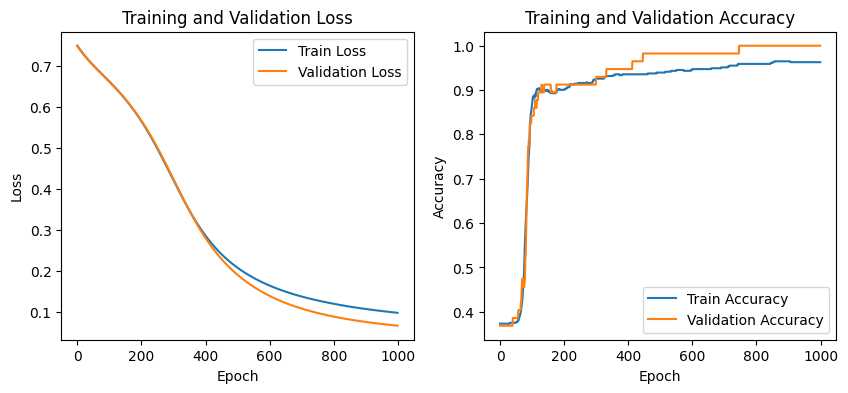

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_losses(plt, "Training and Validation Loss", train_losses, val_losses, label="Loss")
plt.subplot(1, 2, 2)
plot_losses(plt, "Training and Validation Accuracy", train_accuracy, val_accuracy, label="Accuracy")
plt.show()

In [ ]:
"""
At the end of the training print out the following:
    - Accuracy of the model on the validation data
    - Number of epochs to get to that accuracy
    - Criterion used
"""

print(f"Model Accuracy on Validation Data: {best_accuracy:.4f}")
print(f"Number of Epochs to Achieve Best Accuracy: {best_epoch}")
print(f"Criterion Used: {criterion}")

Model Accuracy on Validation Data: 1.0000
Number of Epochs to Achieve Best Accuracy: 1000
Criterion Used: BCELoss()
